In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import optax
from functools import partial 

import matplotlib.pyplot as plt

from water_balance_jax import wbm_jax, construct_Kpet_vec

In [2]:
#####################
#### Directories ####
#####################
project_data_path = '/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA'

In [3]:
subset_name = "centralUS"
obs = "SMAP"

In [57]:
# Read obs
y = np.load(f'{project_data_path}/WBM/precalibration/{subset_name}/{obs}/{obs}_validation.npy')

In [37]:
# Read and extract inputs
npz = np.load(f"{project_data_path}/WBM/precalibration/{subset_name}/{obs}/inputs.npz")

tas = npz['tas']
prcp = npz['prcp']

lai = npz['lai']

awCap = npz['awCap']
wiltingp = npz['wiltingp']

corn = npz['corn']
cotton = npz['cotton']
rice = npz['rice']
sorghum = npz['sorghum']
soybeans = npz['soybeans']
durum_wheat = npz['durum_wheat']
spring_wheat = npz['spring_wheat']
winter_wheat = npz['winter_wheat']

wheat = durum_wheat + spring_wheat + winter_wheat

cropland_other = npz['cropland_other']
water = npz['water']
evergreen_needleleaf = npz['evergreen_needleleaf']
evergreen_broadleaf = npz['evergreen_broadleaf']
deciduous_needleleaf = npz['deciduous_needleleaf']
deciduous_broadleaf = npz['deciduous_broadleaf']
mixed_forest = npz['mixed_forest']
woodland = npz['woodland']
wooded_grassland = npz['wooded_grassland']
closed_shurbland = npz['closed_shurbland']
open_shrubland = npz['open_shrubland']
grassland = npz['grassland']
barren = npz['barren']
urban = npz['urban']

all_other = cropland_other + water + evergreen_needleleaf + evergreen_broadleaf + deciduous_needleleaf + deciduous_broadleaf + mixed_forest + woodland + wooded_grassland + closed_shurbland + open_shrubland + grassland + barren + urban

clayfrac = npz['clayfrac']
sandfrac = npz['sandfrac']
siltfrac = npz['siltfrac']

elev_std = npz['elev_std']

lats = npz['lats']
lons = npz['lons']

Ws_init = npz['soilMoist_init']

In [69]:
nan_inds = jnp.isnan(tas.reshape(nx * ny, nt)).any(axis=1)

In [77]:
# Prepare inputs for vmap: spatial dimensions need to be collapsed and first; NaN gridpoints removed
nx = tas.shape[0]
ny = tas.shape[1]
nt = tas.shape[2]

assert nt % 365 == 0
nyrs = int(nt / 365)

# NaNs
nan_inds = jnp.isnan(tas.reshape(nx * ny, nt)).any(axis=1)

# Obs
ys = y.reshape(nx * ny, nt)[~nan_inds]

#### Forcing
tas_in = tas.reshape(nx * ny, nt)[~nan_inds]
prcp_in = prcp.reshape(nx * ny, nt)[~nan_inds]

lai_in = lai.reshape(nx * ny, 365)[~nan_inds]

awCap_in = awCap.reshape(nx * ny)[~nan_inds]
wiltingp_in = wiltingp.reshape(nx * ny)[~nan_inds]

Ws_init_in = Ws_init.reshape(nx * ny)[~nan_inds]
Wi_init_in = np.zeros(nx * ny)[~nan_inds]
Sp_init_in = np.zeros(nx * ny)[~nan_inds]

clayfrac_in = clayfrac.reshape(nx * ny)[~nan_inds]
sandfrac_in = sandfrac.reshape(nx * ny)[~nan_inds]
siltfrac_in = siltfrac.reshape(nx * ny)[~nan_inds]

lats_in = np.tile(lats, nx)[~nan_inds]
elev_std_in = elev_std.reshape(nx * ny)[~nan_inds]

corn_in = corn.reshape(nx * ny)[~nan_inds]
cotton_in = cotton.reshape(nx * ny)[~nan_inds]
rice_in = rice.reshape(nx * ny)[~nan_inds]
sorghum_in = sorghum.reshape(nx * ny)[~nan_inds]
soybeans_in = soybeans.reshape(nx * ny)[~nan_inds]
wheat_in = wheat.reshape(nx * ny)[~nan_inds]

all_other_in = all_other.reshape(nx * ny)[~nan_inds]

###### Params
awCap_scalar = jnp.log(1.)
wiltingp_scalar = jnp.log(1.)

alpha_claycoef = jnp.log(1.5)
alpha_sandcoef = jnp.log(2)
alpha_siltcoef = jnp.log(3)

betaHBV_claycoef = jnp.log(1.5)
betaHBV_sandcoef = jnp.log(2.3)
betaHBV_siltcoef = jnp.log(3.4)
betaHBV_elevcoef = jnp.log(1.5)

GS_start_corn = jnp.log(1.5)
GS_length_corn = jnp.log(1.5)
L_ini_corn = jnp.log(1.5)
L_dev_corn = jnp.log(1.5)
L_mid_corn = jnp.log(1.5)
Kc_ini_corn = jnp.log(1.5)
Kc_mid_corn = jnp.log(1.5)
Kc_end_corn = jnp.log(1.5)
K_min_corn = jnp.log(1.5)
K_max_corn = jnp.log(1.5)

GS_start_cotton = jnp.log(1.5)
GS_length_cotton = jnp.log(1.5)
L_ini_cotton = jnp.log(1.5)
L_dev_cotton = jnp.log(1.5)
L_mid_cotton = jnp.log(1.5)
Kc_ini_cotton = jnp.log(1.5)
Kc_mid_cotton = jnp.log(1.5)
Kc_end_cotton = jnp.log(1.5)
K_min_cotton = jnp.log(1.5)
K_max_cotton = jnp.log(1.5)

GS_start_rice = jnp.log(1.5)
GS_length_rice = jnp.log(1.5)
L_ini_rice = jnp.log(1.5)
L_dev_rice = jnp.log(1.5)
L_mid_rice = jnp.log(1.5)
Kc_ini_rice = jnp.log(1.5)
Kc_mid_rice = jnp.log(1.5)
Kc_end_rice = jnp.log(1.5)
K_min_rice = jnp.log(1.5)
K_max_rice = jnp.log(1.5)

GS_start_sorghum = jnp.log(1.5)
GS_length_sorghum = jnp.log(1.5)
L_ini_sorghum = jnp.log(1.5)
L_dev_sorghum = jnp.log(1.5)
L_mid_sorghum = jnp.log(1.5)
Kc_ini_sorghum = jnp.log(1.5)
Kc_mid_sorghum = jnp.log(1.5)
Kc_end_sorghum = jnp.log(1.5)
K_min_sorghum = jnp.log(1.5)
K_max_sorghum = jnp.log(1.5)

GS_start_soybeans = jnp.log(1.5)
GS_length_soybeans = jnp.log(1.5)
L_ini_soybeans = jnp.log(1.5)
L_dev_soybeans = jnp.log(1.5)
L_mid_soybeans = jnp.log(1.5)
Kc_ini_soybeans = jnp.log(1.5)
Kc_mid_soybeans = jnp.log(1.5)
Kc_end_soybeans = jnp.log(1.5)
K_min_soybeans = jnp.log(1.5)
K_max_soybeans = jnp.log(1.5)

GS_start_wheat = jnp.log(1.5)
GS_length_wheat = jnp.log(1.5)
L_ini_wheat = jnp.log(1.5)
L_dev_wheat = jnp.log(1.5)
L_mid_wheat = jnp.log(1.5)
Kc_ini_wheat = jnp.log(1.5)
Kc_mid_wheat = jnp.log(1.5)
Kc_end_wheat = jnp.log(1.5)
K_min_wheat = jnp.log(1.5)
K_max_wheat = jnp.log(1.5)

params_in = jnp.array([awCap_scalar, wiltingp_scalar, \
                       alpha_claycoef, alpha_sandcoef, alpha_siltcoef, \
                       betaHBV_claycoef, betaHBV_sandcoef, betaHBV_siltcoef, betaHBV_elevcoef, \
                       GS_start_corn, GS_length_corn, L_ini_corn, L_dev_corn, L_mid_corn, Kc_ini_corn, Kc_mid_corn, Kc_end_corn, K_min_corn, K_max_corn, \
                       GS_start_cotton, GS_length_cotton, L_ini_cotton, L_dev_cotton, L_mid_cotton, Kc_ini_cotton, Kc_mid_cotton, Kc_end_cotton, K_min_cotton, K_max_cotton, \
                       GS_start_rice, GS_length_rice, L_ini_rice, L_dev_rice, L_mid_rice, Kc_ini_rice, Kc_mid_rice, Kc_end_rice, K_min_rice, K_max_rice,  \
                       GS_start_sorghum, GS_length_sorghum, L_ini_sorghum, L_dev_sorghum, L_mid_sorghum, Kc_ini_sorghum, Kc_mid_sorghum, Kc_end_sorghum, K_min_sorghum, K_max_sorghum, \
                       GS_start_soybeans, GS_length_soybeans, L_ini_soybeans, L_dev_soybeans, L_mid_soybeans, Kc_ini_soybeans, Kc_mid_soybeans, Kc_end_soybeans, K_min_soybeans, K_max_soybeans, \
                       GS_start_wheat, GS_length_wheat, L_ini_wheat, L_dev_wheat, L_mid_wheat, Kc_ini_wheat, Kc_mid_wheat, Kc_end_wheat, K_min_wheat, K_max_wheat])

In [40]:
# Constants
Ts = -1. # Snowfall threshold
Tm = 1.  # Snowmelt threshold

In [41]:
# test
ixy = 1050

out = wbm_jax(
    tas=tas_in[ixy, :],
    prcp=prcp_in[ixy, :],
    Kpet=construct_Kpet_vec(GS_start_corn, GS_length_corn, L_ini_corn, L_dev_corn, L_mid_corn, 1. - (L_ini_corn + L_dev_corn + L_mid_corn), Kc_ini_corn, Kc_mid_corn, Kc_end_corn, K_min_corn, K_max_corn, lai_in[ixy,:]),
    Ws_init=Ws_init_in[ixy],
    Wi_init=Wi_init_in[ixy],
    Sp_init=Sp_init_in[ixy],
    lai=lai_in[ixy, :],
    phi=lats_in[ixy],
    params=(Ts, Tm, wiltingp_in[ixy], awCap_in[ixy], 5., 3.),
)

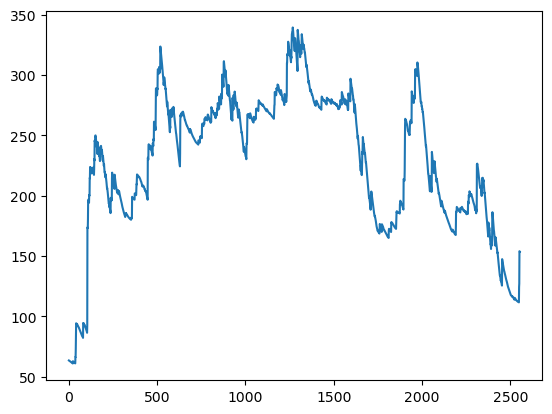

In [42]:
plt.plot(out)

In [43]:
# vmap function (vectorizing map for running WBM over space)
# in_axes define axis that we iterature over for inputs of wbm_jax (i.e. tas, prcp, etc -- all inputs with spatial dimension)
# out_axes define where mapped axis should appear in output
wbm_jax_vmap = jax.jit(jax.vmap(fun=wbm_jax,
                                in_axes=(0, 0, 0, 0, 0, 0, 0, 0, None),
                                out_axes=0))

In [50]:
Kpet_corn = construct_Kpet_vec(GS_start_corn, GS_length_corn, L_ini_corn, L_dev_corn, L_mid_corn, 1. - (L_ini_corn + L_dev_corn + L_mid_corn), Kc_ini_corn, Kc_mid_corn, Kc_end_corn, K_min_corn, K_max_corn, lai_in[ixy,:])
Kpet_cotton = construct_Kpet_vec(GS_start_cotton, GS_length_cotton, L_ini_cotton, L_dev_cotton, L_mid_cotton, 1. - (L_ini_cotton + L_dev_cotton + L_mid_cotton), Kc_ini_cotton, Kc_mid_cotton, Kc_end_cotton, K_min_cotton, K_max_cotton, lai_in[ixy,:])
Kpet_rice = construct_Kpet_vec(GS_start_rice, GS_length_rice, L_ini_rice, L_dev_rice, L_mid_rice, 1. - (L_ini_rice + L_dev_rice + L_mid_rice), Kc_ini_rice, Kc_mid_rice, Kc_end_rice, K_min_rice, K_max_rice, lai_in[ixy,:])
Kpet_sorghum = construct_Kpet_vec(GS_start_sorghum, GS_length_sorghum, L_ini_sorghum, L_dev_sorghum, L_mid_sorghum, 1. - (L_ini_sorghum + L_dev_sorghum + L_mid_sorghum), Kc_ini_sorghum, Kc_mid_sorghum, Kc_end_sorghum, K_min_sorghum, K_max_sorghum, lai_in[ixy,:])
Kpet_soybeans = construct_Kpet_vec(GS_start_soybeans, GS_length_soybeans, L_ini_soybeans, L_dev_soybeans, L_mid_soybeans, 1. - (L_ini_soybeans + L_dev_soybeans + L_mid_soybeans), Kc_ini_soybeans, Kc_mid_soybeans, Kc_end_soybeans, K_min_soybeans, K_max_soybeans, lai_in[ixy,:])
Kpet_wheat = construct_Kpet_vec(GS_start_wheat, GS_length_wheat, L_ini_wheat, L_dev_wheat, L_mid_wheat, 1. - (L_ini_wheat + L_dev_wheat + L_mid_wheat), Kc_ini_wheat, Kc_mid_wheat, Kc_end_wheat, K_min_wheat, K_max_wheat, lai_in[ixy,:])

other = 1. - (corn_in[ixy] + cotton_in[ixy] + rice_in[ixy] + sorghum_in[ixy] + soybeans_in[ixy] + wheat_in[ixy])
Kpet_in = jnp.average(jnp.array([Kpet_corn, Kpet_cotton, Kpet_rice, Kpet_sorghum, Kpet_soybeans, Kpet_wheat, jnp.ones(365)]),
                      weights = jnp.array([corn_in[ixy], cotton_in[ixy], rice_in[ixy], sorghum_in[ixy], soybeans_in[ixy], wheat_in[ixy], other]),
                     axis=0)

In [53]:
len(Kpet_in)

365

In [81]:
def loss_fn(theta,
            tas, prcp, lai,
            awCap, wiltingp,
            Ws_init, Wi_init, Sp_init,
            clayfrac, sandfrac, siltfrac,
            corn, cotton, rice, sorghum, soybeans, wheat,
            phi, elev_std,
            y
           ):
    
    # Read all params
    awCap_scalar, wiltingp_scalar, \
    alpha_claycoef, alpha_sandcoef, alpha_siltcoef, \
    betaHBV_claycoef, betaHBV_sandcoef, betaHBV_siltcoef, betaHBV_elevcoef, \
    GS_start_corn, GS_length_corn, L_ini_corn, L_dev_corn, L_mid_corn, Kc_ini_corn, Kc_mid_corn, Kc_end_corn, K_min_corn, K_max_corn, \
    GS_start_cotton, GS_length_cotton, L_ini_cotton, L_dev_cotton, L_mid_cotton, Kc_ini_cotton, Kc_mid_cotton, Kc_end_cotton, K_min_cotton, K_max_cotton, \
    GS_start_rice, GS_length_rice, L_ini_rice, L_dev_rice, L_mid_rice, Kc_ini_rice, Kc_mid_rice, Kc_end_rice, K_min_rice, K_max_rice,  \
    GS_start_sorghum, GS_length_sorghum, L_ini_sorghum, L_dev_sorghum, L_mid_sorghum, Kc_ini_sorghum, Kc_mid_sorghum, Kc_end_sorghum, K_min_sorghum, K_max_sorghum, \
    GS_start_soybeans, GS_length_soybeans, L_ini_soybeans, L_dev_soybeans, L_mid_soybeans, Kc_ini_soybeans, Kc_mid_soybeans, Kc_end_soybeans, K_min_soybeans, K_max_soybeans, \
    GS_start_wheat, GS_length_wheat, L_ini_wheat, L_dev_wheat, L_mid_wheat, Kc_ini_wheat, Kc_mid_wheat, Kc_end_wheat, K_min_wheat, K_max_wheat \
    = jnp.exp(theta)

    # Construct Kpet as weighted average
    Kpet_corn = construct_Kpet_vec(GS_start_corn, GS_length_corn, L_ini_corn, L_dev_corn, L_mid_corn, 1. - (L_ini_corn + L_dev_corn + L_mid_corn), Kc_ini_corn, Kc_mid_corn, Kc_end_corn, K_min_corn, K_max_corn, lai)
    Kpet_cotton = construct_Kpet_vec(GS_start_cotton, GS_length_cotton, L_ini_cotton, L_dev_cotton, L_mid_cotton, 1. - (L_ini_cotton + L_dev_cotton + L_mid_cotton), Kc_ini_cotton, Kc_mid_cotton, Kc_end_cotton, K_min_cotton, K_max_cotton, lai)
    Kpet_rice = construct_Kpet_vec(GS_start_rice, GS_length_rice, L_ini_rice, L_dev_rice, L_mid_rice, 1. - (L_ini_rice + L_dev_rice + L_mid_rice), Kc_ini_rice, Kc_mid_rice, Kc_end_rice, K_min_rice, K_max_rice, lai)
    Kpet_sorghum = construct_Kpet_vec(GS_start_sorghum, GS_length_sorghum, L_ini_sorghum, L_dev_sorghum, L_mid_sorghum, 1. - (L_ini_sorghum + L_dev_sorghum + L_mid_sorghum), Kc_ini_sorghum, Kc_mid_sorghum, Kc_end_sorghum, K_min_sorghum, K_max_sorghum, lai)
    Kpet_soybeans = construct_Kpet_vec(GS_start_soybeans, GS_length_soybeans, L_ini_soybeans, L_dev_soybeans, L_mid_soybeans, 1. - (L_ini_soybeans + L_dev_soybeans + L_mid_soybeans), Kc_ini_soybeans, Kc_mid_soybeans, Kc_end_soybeans, K_min_soybeans, K_max_soybeans, lai)
    Kpet_wheat = construct_Kpet_vec(GS_start_wheat, GS_length_wheat, L_ini_wheat, L_dev_wheat, L_mid_wheat, 1. - (L_ini_wheat + L_dev_wheat + L_mid_wheat), Kc_ini_wheat, Kc_mid_wheat, Kc_end_wheat, K_min_wheat, K_max_wheat, lai)

    other = 1. - (corn + cotton + rice + sorghum + soybeans + wheat)
    weights = jnp.array([corn, cotton, rice, sorghum, soybeans, wheat, other])
    Kpets = jnp.array([Kpet_corn, Kpet_cotton, Kpet_rice, Kpet_sorghum, Kpet_soybeans, Kpet_wheat, jnp.ones(365)])
    Kpet = jnp.average(Kpets, weights = weights, axis=0)
    
    # params that WBM sees
    awCap_in = awCap * awCap_scalar
    wiltingp_in = wiltingp * wiltingp_scalar
    alpha = 1.0 + (alpha_claycoef * clayfrac) + (alpha_sandcoef * sandfrac) + (alpha_siltcoef * siltfrac)
    betaHBV = 1.0 + (betaHBV_claycoef * clayfrac) + (betaHBV_sandcoef * sandfrac) + (betaHBV_siltcoef * siltfrac) + (betaHBV_elevcoef * elev_std)
    
    params = (Ts, Tm, wiltingp, awCap, alpha, betaHBV)
    
    # Make prediction
    prediction = wbm_jax(
        tas,
        prcp, 
        Kpet,
        Ws_init,
        Wi_init,
        Sp_init,
        lai,
        phi,
        params
    )
    # Return RMSE 
    return jnp.nanmean((prediction-y)**2)

In [1]:
# test
ixy = 1058

loss_fn(
    theta=params_in,
    tas=tas_in[ixy, :],
    prcp=prcp_in[ixy, :],
    lai=lai_in[ixy, :],
    awCap = awCap_in[ixy],
    wiltingp = wiltingp_in[ixy],
    Ws_init = Ws_init_in[ixy],
    Wi_init = Wi_init_in[ixy],
    Sp_init = Sp_init_in[ixy],
    clayfrac = clayfrac_in[ixy],
    sandfrac = sandfrac_in[ixy],
    siltfrac = siltfrac_in[ixy],
    corn = corn_in[ixy],
    cotton = cotton_in[ixy],
    rice = rice_in[ixy],
    sorghum = sorghum_in[ixy],
    soybeans = soybeans_in[ixy],
    wheat = wheat_in[ixy],
    phi = lats_in[ixy],
    elev_std = elev_std_in[ixy],
    y = ys[ixy]
)

NameError: name 'loss_fn' is not defined

In [33]:
loss_grad = jax.jit(jax.vmap(jax.grad(loss_fn), in_axes=(None, 0, 0, None, 0), out_axes=0))
loss_value_and_grad = jax.jit(jax.vmap(jax.value_and_grad(loss_fn), in_axes=(None, 0, 0, None, 0), out_axes=0))

In [37]:
%%time

# Define mini-batch hyper-parameters
N = x_forcing.shape[0]
batch_size = 2**7
n_minibatches = N // batch_size

# Initial parameters
theta = jnp.array([5., 5., 5., 5., 5., 5., 1., 1., 1., 1., 1., 1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])
# theta = theta_true * 0.99

# Optimizer
adam = optax.adam(learning_rate=1e-2)
opt_fn = adam.update
opt_state = adam.init(theta)

# adagrad = optax.adagrad(learning_rate = 0.01)
# opt_fn = adagrad.update
# opt_state = adagrad.init(theta)

# SGD optimizers
# learning_rate = 1e-5
# opt_state = None
# def sgd(gradients, state):
#     return -learning_rate * gradients, state
# opt_fn = sgd

# Epochs
n_epochs = 50

# Loss
loss_out = np.empty(n_epochs)

for epoch in range(n_epochs):
    # Shuffle indices
    shuffled_inds = np.random.permutation(N)
    
    # Generate a mini-batch
    minibatch_inds = [shuffled_inds[(i*batch_size):((i + 1)*batch_size)] for i in range(n_minibatches + 1)]

    for inds in minibatch_inds:
        x_forcing_batch = x_forcing[inds]
        x_map_batch = x_maps[inds]
        ys_batch = ys_nnan[inds]
    
        # Calculate gradient of loss function, update parameters
        loss, grads = loss_value_and_grad(theta, x_forcing_batch, x_map_batch, x_const, ys_batch)
        updates, opt_state = opt_fn(jnp.mean(grads, axis=0), opt_state)
        theta = optax.apply_updates(theta, updates)

    # Store loss
    loss_out[epoch] = jnp.mean(loss)
    if epoch % 5 == 0:
        print(f"Epoch {str(epoch)}, loss: {loss_out[epoch]:.2f}")
    if jnp.sum(jnp.isnan(loss)):
        break

Epoch 0, loss: 258.13
Epoch 5, loss: 23.96
Epoch 10, loss: 6.59
Epoch 15, loss: 2.85
Epoch 20, loss: 0.84
Epoch 25, loss: 0.60
Epoch 30, loss: 0.52
Epoch 35, loss: 0.70
Epoch 40, loss: 0.28
Epoch 45, loss: 0.33
CPU times: user 22min 9s, sys: 1min 42s, total: 23min 51s
Wall time: 23min 58s
